# Superpixels

In [16]:
import numpy as np
from sklearn.cluster import KMeans
from scipy import sparse
from scipy.sparse.linalg import eigsh
import cv2
import matplotlib.pyplot as plt

## Methods

In [28]:
def compute_weights(image, radius, sigma_color, sigma_space):
    height, width = image.shape[:2]
    weights, row_inds, col_inds = [], [], []

    image = image.astype(float)

    for i in range(height):
        for j in range(width):
            for di in range(max(0, i-radius), min(height, i+radius+1)):
                for dj in range(max(0, j-radius), min(width, j+radius+1)):
                    if i == di and j == dj:
                        continue

                    color_dist = np.sum((image[i,j] - image[di,dj])**2)
                    space_dist = (i-di)**2 + (j-dj)**2

                    if space_dist <= radius**2:
                        weight = np.exp(-color_dist/(2*sigma_color**2)) * \
                                np.exp(-space_dist/(2*sigma_space**2))

                        weights.append(weight)
                        row_inds.append(i*width + j)
                        col_inds.append(di*width + dj)

    return sparse.csr_matrix((weights, (row_inds, col_inds)),
                           shape=(height*width, height*width))

def compute_normalized_cut(W):
    d = np.array(W.sum(axis=1)).flatten()
    D = sparse.diags(d)

    L = D - W

    d_sqrt_inv = sparse.diags(1.0 / np.sqrt(d + 1e-10))  # avoiding division by zero
    L_norm = d_sqrt_inv @ L @ d_sqrt_inv

    eigenvalues, eigenvectors = eigsh(L_norm, k=5, which='SM')

    return eigenvectors

def segment_image(image, n_segments, radius, sigma_color, sigma_space):
    W = compute_weights(image, radius, sigma_color, sigma_space)

    eigenvectors = compute_normalized_cut(W)

    kmeans = KMeans(n_clusters=n_segments, random_state=42)
    labels = kmeans.fit_predict(eigenvectors)

    height, width = image.shape[:2]
    segmentation = labels.reshape(height, width)

    return segmentation

## Execution

<Figure size 1000x500 with 0 Axes>

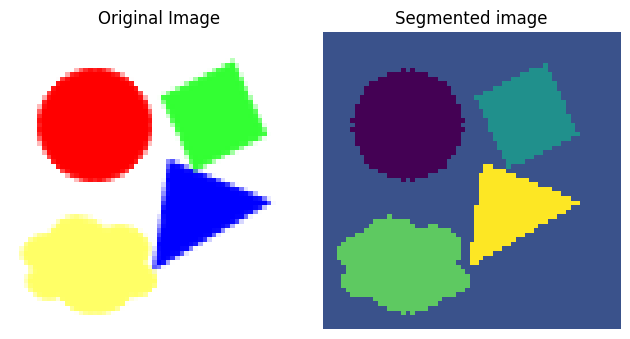

In [29]:
image = cv2.imread('superpixels.png')

segmentation = segment_image(
    image,
    n_segments=5,
    radius=5,
    sigma_color=20,
    sigma_space=4
)

colors = np.random.randint(0, 255, (5, 3))
colors[0] = [255, 255, 255]

plt.figure(figsize=(10, 5))

f, arr = plt.subplots(1,2)

arr[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
arr[0].set_title('Original Image')
arr[0].axis('off')

arr[1].imshow(segmentation)
arr[1].set_title('Segmented image')
arr[1].axis('off')

plt.tight_layout()
plt.show()